In [66]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from scipy import stats
#import warnings
#warnings.simplefilter('ignore')


In [4]:
data = pd.read_csv('term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
#We don't have any missing values
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [6]:
#Lets take a look at the type of our features
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [7]:
data.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [8]:
#So we will have a inbalanced dataset, there are multiple techniques to deal with that, we will come to this later.
data.y.value_counts()

no     37104
yes     2896
Name: y, dtype: int64

Let's investitage the distribution of some of our features 

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='balance', ylabel='Density'>

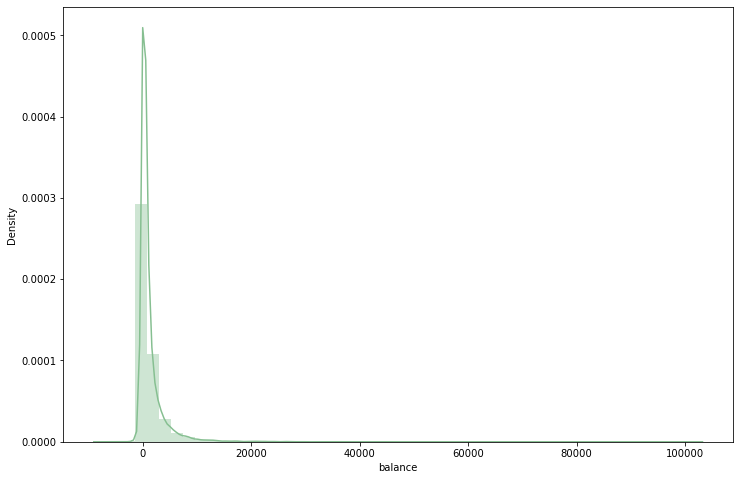

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(data.balance,color='#86bf91')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

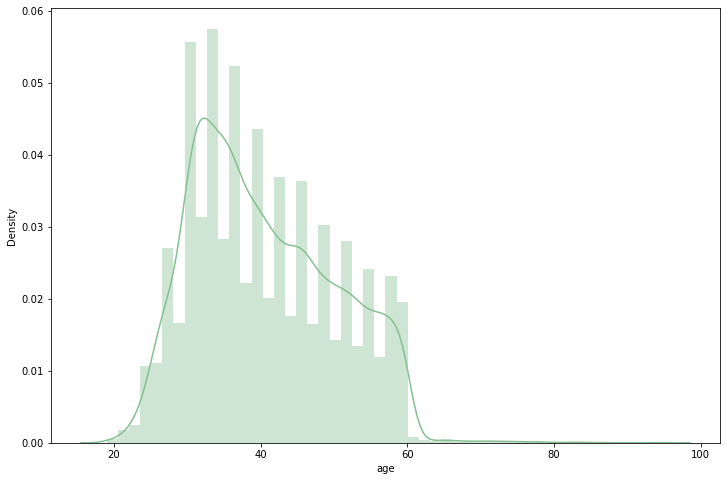

In [14]:
plt.figure(figsize=(12,8))
sns.distplot(data.age,color='#86bf91')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

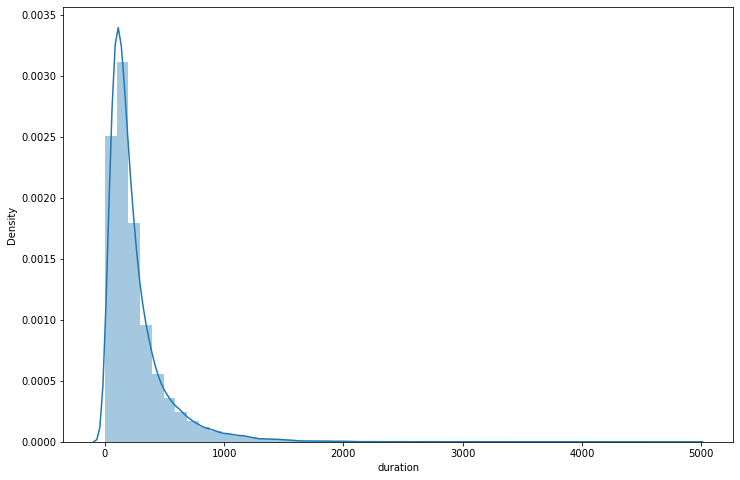

In [18]:
plt.figure(figsize=(12,8))
sns.distplot(data.duration)

In [19]:
#Getting the continous features to observe the relationship between them, and the target variable y.
continousFeatures = data._get_numeric_data().columns.tolist()
plotFeatures = continousFeatures  + ['y']

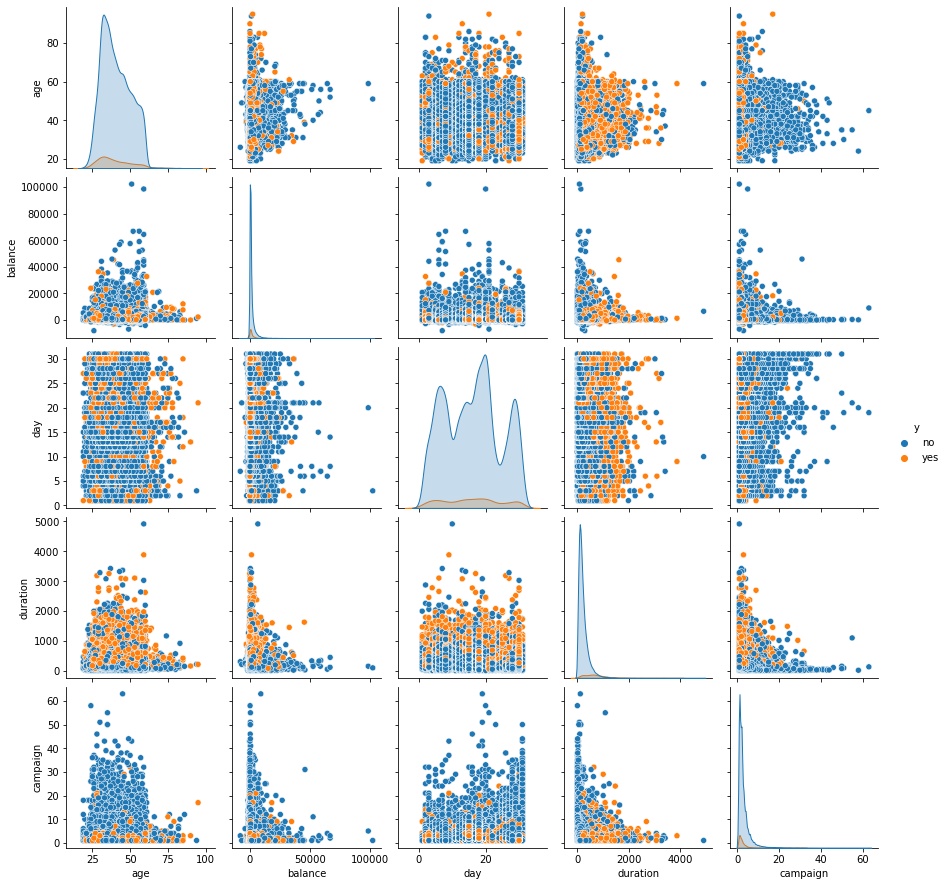

In [20]:
sns.pairplot(data = data[plotFeatures],hue = 'y')

Well, it looks like, there is no linear relationship between our continous features. This is kind of interesting because I expect to at least obsverse more of a linear relationship between age and balance. Another takeouts from this plot:
- From the campaing distrubition, we can see that as the campaign number increases, subscribe rate of customers definitely decreases / diminishes as there is only customers that didn't subscribe at the right tail of the distribution

- There is no clear discrimination for the balances. Although users with low balances and high balances has a tendency to say no to subscription, middle ranges values follows similiar distribution.

Let's investigate the relationship further between our independent features and target variable to get a feel of the data.

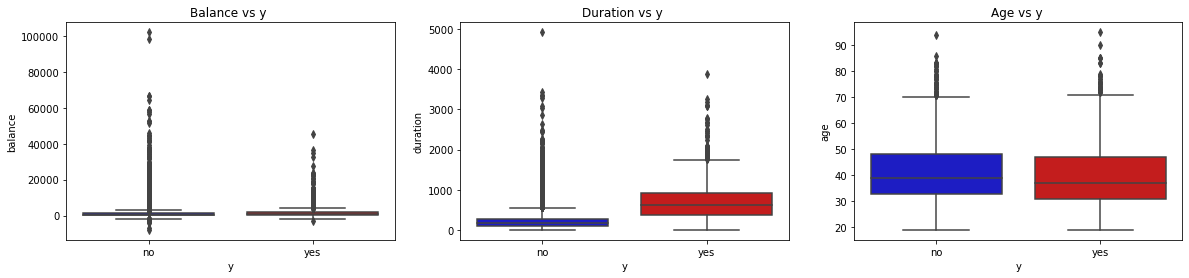

In [22]:
colors = ["#0101DF", "#DF0101"]
f, axes = plt.subplots(ncols=3, figsize=(20,4))

sns.boxplot(x="y", y="balance", data=data, palette=colors, ax=axes[0])
axes[0].set_title('Balance vs y ')

sns.boxplot(x="y", y="duration", data=data, palette=colors, ax=axes[1])
axes[1].set_title('Duration vs y ')


sns.boxplot(x="y", y="age", data=data, palette=colors, ax=axes[2])
axes[2].set_title('Age vs y ')



plt.show()

It looks like from the boxplot of the duration vs y, when we take more time to contact customers, we will get a higher chance that they'll subscribe. Thus, duration will probably be a good parameter for our model.

Feature Creation

First, I want to create a feature called Season to see if the users inclined to subscripe during different seasons

In [23]:
data.month.value_counts()

may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec       13
Name: month, dtype: int64

In [24]:
autumn_list = ['sep','oct','nov']
spring_list = ['mar','apr','may']
summer_list = ['jun','jul','aug']
winter_list = ['dec','jan','feb']

def get_season(row):
    
    if row['month'] in autumn_list:
            return 'autumn'
    if row['month'] in spring_list:
            return 'spring'
    if row['month'] in summer_list:
            return 'summer'
    if row['month'] in winter_list:
            return 'winter'

In [25]:

data['season'] = data.apply (lambda row: get_season(row), axis=1)
data.head()



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,season
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no,spring
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no,spring
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no,spring
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no,spring
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no,spring


As I stated before, there is a class imbalance in our dataset. There are 37104 samples with no subscription 
and only 2896 samples who subscripted. If we don't tackle this problem, our machine learning model will heavily
overestimate no subscription rate. Easiest way to handle this is undersampling the sample with y = 0. We will randomly unsersample the observations with y = 0 and plot the distributions.

In [28]:
#First, binarizing the target variable y
lb = LabelBinarizer()
data['y'] = lb.fit_transform(data['y'])
data.y.value_counts()

0    37104
1     2896
Name: y, dtype: int64

In [29]:
df = data.sample(frac=1).copy()
yes_df = df[df.y==1]
no_df = df[df.y == 0][0:2896]
normal_distributed_df = pd.concat([yes_df, no_df])
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,season
2347,33,management,divorced,secondary,no,5,yes,no,unknown,13,may,1346,1,1,spring
10555,36,services,married,secondary,no,981,no,no,unknown,16,jun,1093,1,1,summer
29313,39,services,married,secondary,no,52,no,no,telephone,2,feb,1420,3,1,winter
31206,35,services,married,secondary,no,52,yes,no,cellular,2,mar,378,4,1,spring
7916,31,unemployed,divorced,primary,no,0,yes,no,unknown,30,may,745,12,1,spring


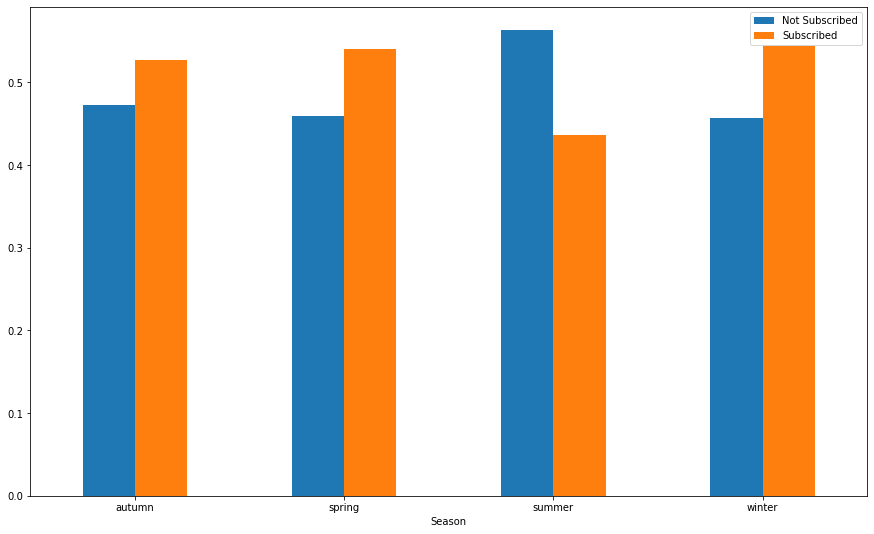

In [31]:
ax = new_df.groupby('season')['y'].value_counts(normalize=True).unstack('y').plot(kind='bar',figsize=(15,9),rot=0)
ax.legend(['Not Subscribed','Subscribed'])
ax.set_xlabel('Season')
ax.set_ylabel = ('Percentages')

It looks like subscription rate decreases in summer as it is the only season that has higher percentage of customers that didn't subscribe.

In [33]:
#Binning the age column to see if age has effect on subscription
bins = [df.age.min(), 35, 50, np.inf]
labels = ['young','middle','older']

new_df['binned'] = pd.cut(new_df['age'],bins=bins,labels=labels)
new_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,season,binned
2347,33,management,divorced,secondary,no,5,yes,no,unknown,13,may,1346,1,1,spring,young
10555,36,services,married,secondary,no,981,no,no,unknown,16,jun,1093,1,1,summer,middle
29313,39,services,married,secondary,no,52,no,no,telephone,2,feb,1420,3,1,winter,middle
31206,35,services,married,secondary,no,52,yes,no,cellular,2,mar,378,4,1,spring,young
7916,31,unemployed,divorced,primary,no,0,yes,no,unknown,30,may,745,12,1,spring,young


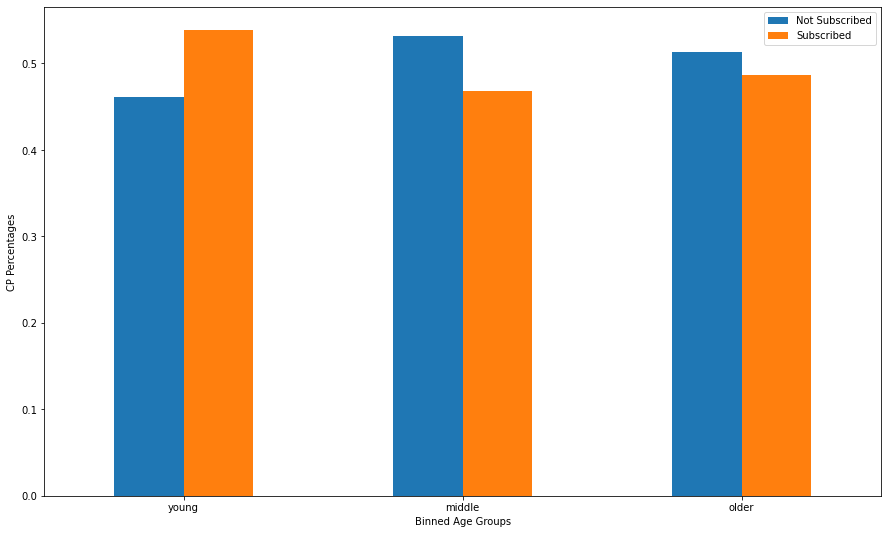

In [35]:
ax = new_df.groupby('binned')['y'].value_counts(normalize=True).unstack('y').plot(kind='bar',figsize=(15,9),rot=0)
ax.legend(['Not Subscribed','Subscribed'])
ax.set_xlabel("Binned Age Groups");
ax.set_ylabel("CP Percentages");

Well, it looks like younger customers are more inclined to make the purchase

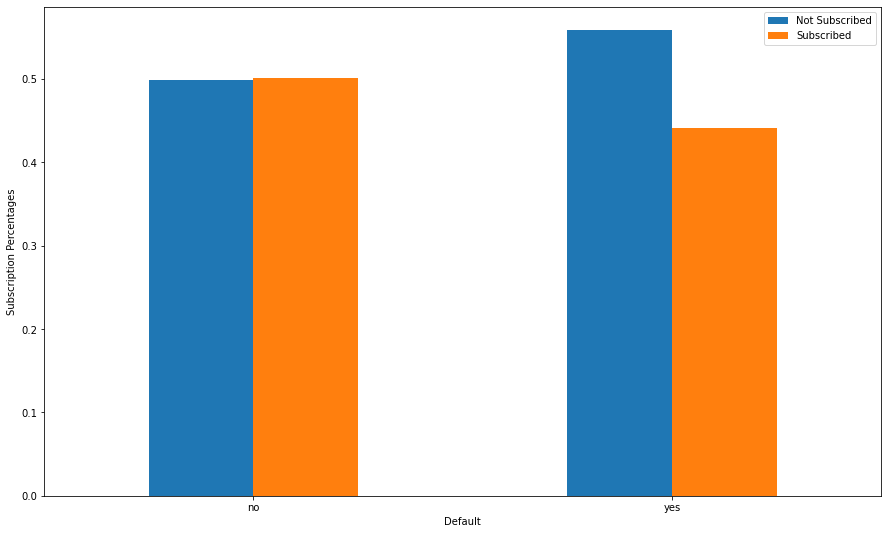

In [37]:
ax = new_df.groupby('default')['y'].value_counts(normalize=True).unstack('y').plot(kind='bar',figsize=(15,9),rot=0)
ax.legend(['Not Subscribed','Subscribed'])
ax.set_xlabel("Default");
ax.set_ylabel("Subscription Percentages");

It looks like customers that defaulted is more reluctant to subscribe

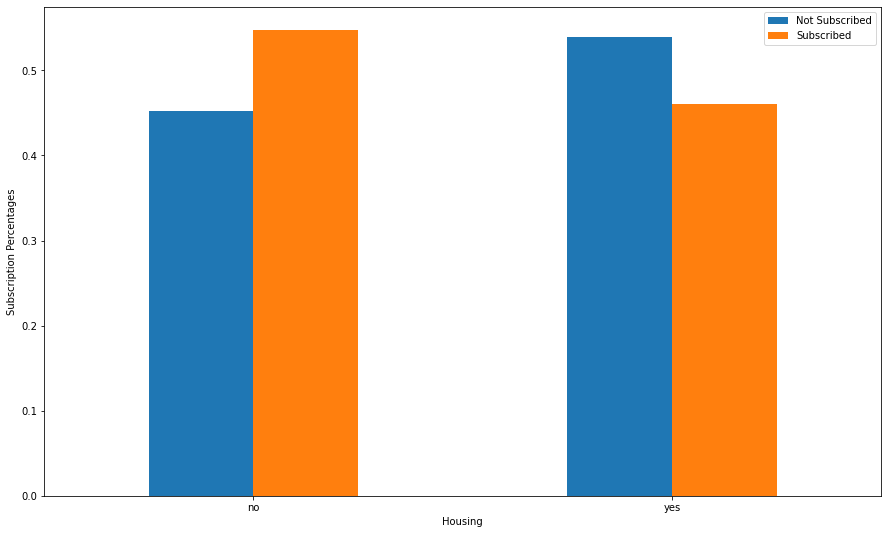

In [38]:
ax = new_df.groupby('housing')['y'].value_counts(normalize=True).unstack('y').plot(kind='bar',figsize=(15,9),rot=0)
ax.legend(['Not Subscribed','Subscribed'])
ax.set_xlabel("Housing");
ax.set_ylabel("Subscription Percentages");

So it looks like that customers that who have housing loans are more reluctant to subscribe.

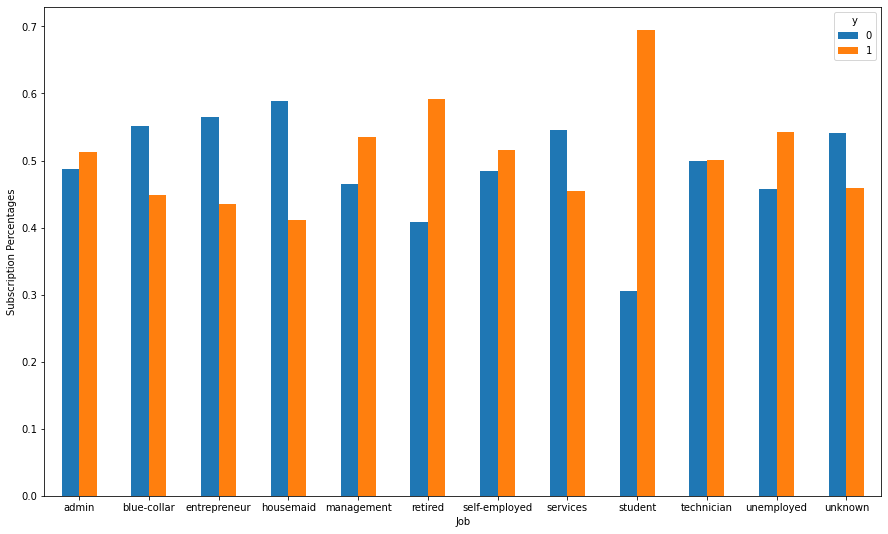

In [39]:
ax = new_df.groupby('job')['y'].value_counts(normalize=True).unstack('y').plot(kind='bar',figsize=(15,9),rot=0)
ax.set_xlabel("Job");
ax.set_ylabel("Subscription Percentages");

It looks like from the above graph, student, retired and unemployed customers are more likely to subscribe.

Let's transform some of our continous variables to make them more normally distributed, then we will standard scale them. After that we will be one hot encoding the categorical features to feed the data into ml models.

In [65]:
new_df.describe()

,age,balance,day,duration,campaign,y
count,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000
mean,40.279006,1425.148481,16.009323,448.704247,2.668854,0.500000
std,10.338454,3237.787577,8.418200,408.759385,2.849802,0.500043
min,19.000000,-4057.000000,1.000000,1.000000,1.000000,0.000000
25%,32.000000,89.000000,9.000000,144.000000,1.000000,0.000000
50%,38.000000,486.000000,16.000000,308.000000,2.000000,0.500000
75%,48.000000,1524.500000,22.000000,656.250000,3.000000,1.000000
max,95.000000,98417.000000,31.000000,3881.000000,39.000000,1.000000


We will use boxcox transformation to get rid of the skewness in some of our features. Boxcox transformation only accepts features with min value > 0. Thus we will ve selection duration and campaign

In [77]:
boxcoxFeatures = ['duration','campaign']

In [78]:
train_transformed = new_df.copy()

for col in boxcoxFeatures:
    train_transformed[col],_ = stats.boxcox(train_transformed[col])

duration
campaign


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

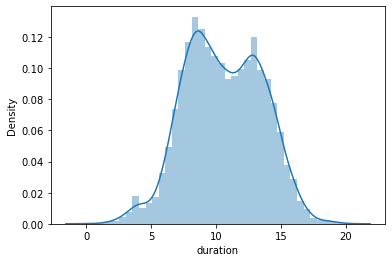

In [79]:
sns.distplot(train_transformed['duration'])

In [80]:
#Standard Scaling the continous features
scaler = StandardScaler()



train_transformed[continousFeatures]  = scaler.fit_transform(train_transformed[continousFeatures])
train_transformed[continousFeatures].head()

,age,balance,day,duration,campaign
2347,-0.704132,-0.438655,-0.357509,1.687543,-1.106018
10555,-0.413928,-0.137188,-0.001108,1.414022,-1.106018
29313,-0.123724,-0.424137,-1.664315,1.759637,0.775045
31206,-0.510663,-0.424137,-1.664315,0.177476,1.095932
7916,-0.897601,-0.440199,1.662099,0.938261,1.920998


In [81]:
#I mentioned that there are other techniques to deal with class imbalances before (like oversampling using SMOTE),
#but I choose to use undersampling because there are high number of cases where y=1 in the dataset.

train_transformed.y.value_counts()


1    2896
0    2896
Name: y, dtype: int64

In [82]:
# constructing Y, and one hot encoding the categorical features
Y = train_transformed['y']
X_train = pd.get_dummies(train_transformed.drop('y',axis=1),drop_first=True)
X_train.head()

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_jun,month_mar,month_may,month_nov,month_oct,season_spring,season_summer,season_winter,binned_middle,binned_older
2347,-0.704132,-0.438655,-0.357509,1.687543,-1.106018,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
10555,-0.413928,-0.137188,-0.001108,1.414022,-1.106018,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
29313,-0.123724,-0.424137,-1.664315,1.759637,0.775045,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
31206,-0.510663,-0.424137,-1.664315,0.177476,1.095932,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
7916,-0.897601,-0.440199,1.662099,0.938261,1.920998,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


It is time for prediction! I will be choosing several classifiers and then combine the results of all of them using bagging the increase the accuracy. First define our accuracy metric, and see how different models perform without any hyperparameter tuning

In [56]:
from sklearn.model_selection import cross_val_score
def cv_accuracy(model,X,y,cv_num):
    return cross_val_score(model, X, y, cv=cv_num).mean()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

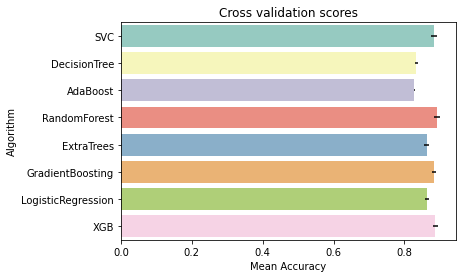

In [85]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import  StratifiedKFold, learning_curve
from xgboost import XGBClassifier

random_state = 2

#kfold = StratifiedKFold(n_splits=5)
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(XGBClassifier(n_estimators=100))


cv_results = []

for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y, scoring = "accuracy", cv = 5))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","LogisticRegression","XGB"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [88]:
cv_res.sort_values(by='CrossValMeans',ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
3,0.891401,0.008244,RandomForest
7,0.887260,0.007515,XGB
5,0.882598,0.005950,GradientBoosting
0,0.882422,0.008237,SVC
6,0.864469,0.006043,LogisticRegression
4,0.862742,0.007175,ExtraTrees
1,0.833738,0.005193,DecisionTree
2,0.828211,0.002721,AdaBoost


It looks like top performing models without hyperparameter tuning are RandomForest,XGB,GradientBoosting,SVC and LogisticRegression. Next, I will tune their parameters one by one and combine the improved models for prediction. (By the way, we have already 0.89 5 fold cross validation score only from Random Forest already!)

In [91]:
#Starting with RandomForest
from sklearn.model_selection import GridSearchCV
n_estimators = [10, 30, 50, 100]
max_depth = [5, 8, 15]
min_samples_split = [2, 5, 10, 15, 40]
min_samples_leaf = [1, 2, 5, 10] 


hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

rf_model = RandomForestClassifier(random_state=random_state)
gridF = GridSearchCV(rf_model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, Y)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.2min finished


In [94]:
RF_best = bestF.best_estimator_

In [97]:
#Next is SVC

SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=3, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   42.4s
[Parallel(n_jobs=4)]: Done  84 out of  84 | elapsed:  1.6min finished


0.8800071374331536

In [98]:
#Moving on the next model: Graident Boosting
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=3, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:   34.9s finished


0.8824245627874986

In [99]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=3, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 162 out of 162 | elapsed:   28.8s finished


0.8813885616820015

In [106]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=3, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y)

ada_best = gsadaDTC.best_estimator_

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:    4.7s finished


In [111]:
xgb = XGBClassifier(n_estimators=100)
# construct the ensemble classifier
clf = VotingClassifier(estimators = [('rf',RF_best), ('svm',SVMC_best),('GBC',GBC_best),('ExtC',ExtC_best),('Ada',ada_best),('XGB',xgb)], voting='soft') 

In [112]:
cv_accuracy(clf,X_train,Y,cv_num=5)

0.8924379452836627

Our final model have %89.2 5 fold cross validation score! Moving on to the feature importance. During our analysis in the beginning, looking at the distributions we guessed that some of the features may be important to our model. Let's see if this is the case.

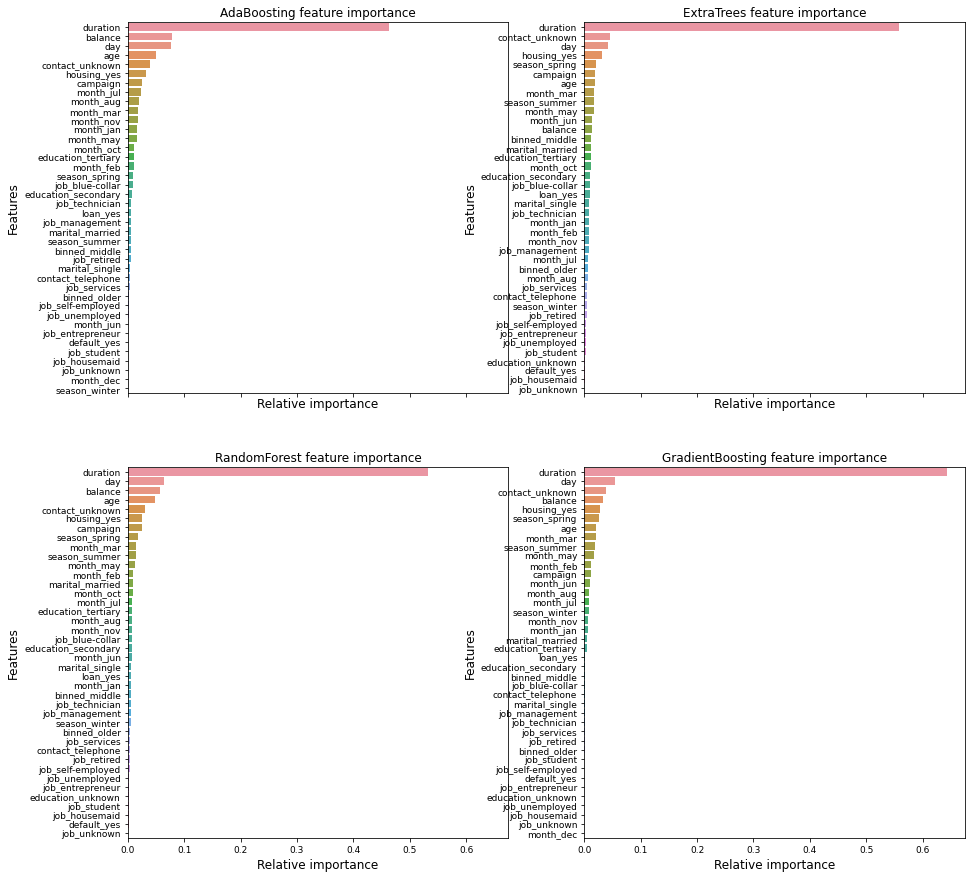

In [110]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RF_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

Duration is the most important feature for all of our classifiers. Also day,balance,housing and age are the some of the most important features for our classifiers. Observing the day here is kind of interesting let's look at distribution of day more closely.

<AxesSubplot:xlabel='day', ylabel='count'>

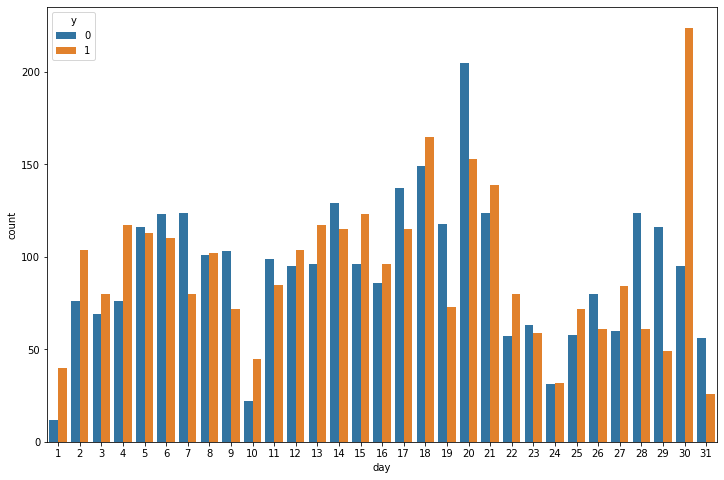

In [120]:
plt.figure(figsize=(12,8))
sns.countplot(x='day',hue='y',data=new_df)